In [1]:
import gensim.downloader as api

#pretrained Word2Vec model
model = api.load("word2vec-google-news-300")

[=================================================-] 99.9% 1660.7/1662.8MB downloaded


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from gensim.models import Word2Vec

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Part 1

# Finding similar words

In [8]:
new_words = ["cat", "dog", "apple", "banana", "computer"]

# Find and print similar words for each of the new words
for word in new_words:
    print(f"Similar words to '{word}':")
    try:
        similar_words = model.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"  Word '{word}' not in vocabulary.")
    print()

Similar words to 'cat':
  cats: 0.8099
  dog: 0.7609
  kitten: 0.7465
  feline: 0.7326
  beagle: 0.7151

Similar words to 'dog':
  dogs: 0.8680
  puppy: 0.8106
  pit_bull: 0.7804
  pooch: 0.7627
  cat: 0.7609

Similar words to 'apple':
  apples: 0.7204
  pear: 0.6451
  fruit: 0.6410
  berry: 0.6302
  pears: 0.6134

Similar words to 'banana':
  bananas: 0.7524
  pineapple: 0.6588
  mango: 0.6365
  pineapples: 0.6314
  papaya: 0.6064

Similar words to 'computer':
  computers: 0.7979
  laptop: 0.6640
  laptop_computer: 0.6549
  Computer: 0.6473
  com_puter: 0.6082



In [9]:
#Finding similar word based on analogy (king - man + woman = queen)
analogies = [("boy", "man", "girl"),  ("paris", "france", "berlin"), ("air","plane", "water")]

for a, b, c in analogies:
    result = model.most_similar(positive=[b, c], negative=[a], topn=1)
    print(f"{a} is to {b} as {c} is to:")
    print(f"  {result[0][0]} (similarity: {result[0][1]:.4f})")
    print()

boy is to man as girl is to:
  woman (similarity: 0.8713)

paris is to france as berlin is to:
  germany (similarity: 0.5094)

air is to plane as water is to:
  boat (similarity: 0.4815)



## Part 2

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

C:\Users\Kids\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

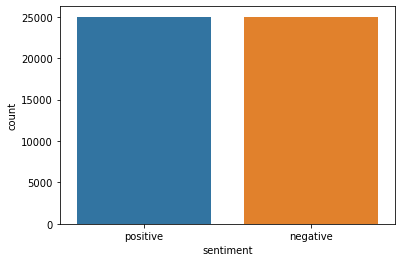

In [12]:
sns.countplot(df['sentiment'])

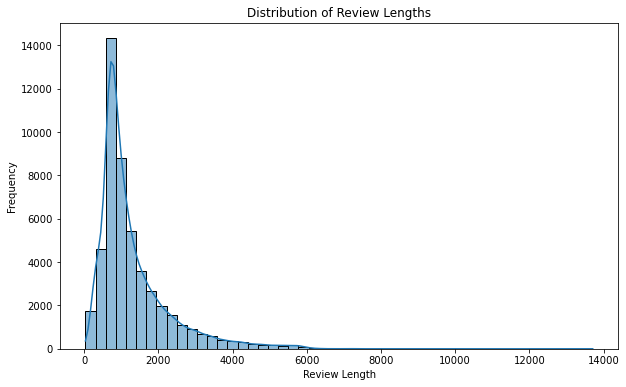

In [13]:
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
df['review_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64

In [15]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kids\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kids\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
sentences = [review.split() for review in df['cleaned_review']]

In [17]:
skipgram = Word2Vec(sentences,sg=1,vector_size=50, window=5, min_count=1)
cbow = Word2Vec(sentences, sg=0,vector_size=50,window=5,min_count=1)

In [18]:
def get_average_vector(sentence, model):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['skipgram_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, skipgram))
df['cbow_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, cbow))

In [19]:
def regression(x_train, x_test, y_train, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    return classification_report(y_test, y_pred)

In [20]:
sx = np.array(df['skipgram_vector'].tolist())
cx = np.array(df['cbow_vector'].tolist())
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

sx_train, sx_test, y_train, y_test = train_test_split(sx, y, test_size=0.2, random_state=42)
cx_train, cx_test, _, _ = train_test_split(cx, y, test_size=0.2, random_state=42)


# SKIPGRAM MODEL

In [21]:
print("Skip-gram Model:")
print(regression(sx_train, sx_test, y_train, y_test))

Skip-gram Model:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4961
           1       0.86      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# CBoW MODEL

In [22]:
print("CBoW Model:")
print(regression(cx_train, cx_test, y_train, y_test))

CBoW Model:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [23]:
def get_average_vector(sentence, model):
    words = sentence.split()
    vectors = [model[word] for word in words if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['new_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, model))

# PRETRAINED WORD2VEC MODEL

In [24]:
new_x = np.array(df['new_vector'].tolist())
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

new_x_train, new_x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.2, random_state=42)

print("Pretrained Word2Vec Model:")
print(regression(new_x_train, new_x_test, y_train, y_test))

Pretrained Word2Vec Model:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

